# Hands-on Tutorial V

## Introduction to thermal properties with GreenALM


In [15]:
# add utils libary
import sys
from pathlib import Path

file = Path().cwd()
if file not in sys.path:
    sys.path.append(file)

from typing import Dict, Sequence
from pprint import pprint, pformat    
    
# Load with magic commands
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

import numpy as np

from pymatgen import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from thermal_exp.core.eos import EosFactory
from thermal_exp.core.quasiharmonic import QuasiharmonicApprox

from gfalm.notebook.session import ParallelGreenAlmSession
from gfalm.notebook.session import init_client

from gfalm_utils.adapter import PymatgenStructureAdapter
from gfalm_utils.utils import change_concentrations

client = init_client('mpi')

print("Loading of modules was successful!")

Loading of modules was successful!


### 1. Thermal expansion of Gold

In [16]:
# Create pymatgen structure
structure = Structure(
    lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
    species=['Au'],
    coords=[[0.0, 0.0, 0.0]],
)

In [17]:
# Number of evaluation points
points = 8

# Set up the range for the calculations
volumes = np.linspace(14, 19, points)

# Temperature
temperature = 300



# Define an list for the free energies
free_energies = []

with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    for idx, volume in enumerate(volumes):

        session.reset_pbar()
        session.write(f"Calculating for volume: {volume:.6f} ang^3", file=sys.stderr)

        base_input_params = session.read_input_file("input/base.in")
        result = session.run_main(
            PymatgenStructureAdapter(
                structure, base_input_params, volume=volume, name=f"au-{volume:.6f}"
            )
        )
        energy = result["general"].total_free_energy

        session.write(f"Free energy: {energy:.6f}", file=sys.stderr)

        free_energies.append(energy)
        
print("Calculations are ready!")

Calculating for volume: 14.000000 ang^3          
Free energy: -38075.340066                                                           
Calculating for volume: 14.714286 ang^3                                         
Free energy: -38075.353846                                                        
Calculating for volume: 15.428571 ang^3                                      
Free energy: -38075.361836                                                           
Calculating for volume: 16.142857 ang^3                                         
Free energy: -38075.365437                                                           
Calculating for volume: 16.857143 ang^3                                         
Free energy: -38075.365750                                                           
Calculating for volume: 17.571429 ang^3                                         
Free energy: -38075.363655                                                          
Calculating for volume: 18.285714 an

Calculations are ready!


In [18]:
eos_base = EosFactory("birch_murnaghan", volumes, free_energies)

debye_model = QuasiharmonicApprox(volumes, free_energies, structure)
thermal_energies = debye_model.vibrational_free_energies(temperature, volumes)
free_energies_total = thermal_energies + free_energies

eos = EosFactory("birch_murnaghan", volumes, free_energies_total)

def volume_to_lattice_constant(volume: float) -> float:
    return (volume * 4)**(1/3)

print(eos_base.volume_eq)
print(eos.volume_eq)
print(volume_to_lattice_constant(eos_base.volume_eq))
print(volume_to_lattice_constant(eos.volume_eq))
print(eos.bulk_modulus_eq.to("GPa"))

16.576934563692667 ang^3
16.75369428573297 ang^3
4.047511314708073 ang
4.061846675893088 ang
182.1723569820066 GPa


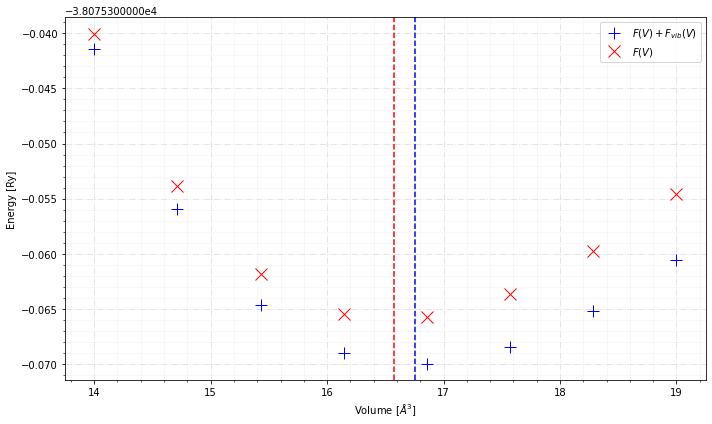

In [19]:
### Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Volume [$\AA^3$]")
ax.set_ylabel("Energy [Ry]")
ax.grid(b=True, which="major", color="grey", alpha=0.2, linestyle="dashdot", lw=1.0)
ax.minorticks_on()
ax.grid(b=True, which="minor", color="lightgrey", alpha=0.3, ls="-", lw=0.5)
ax.plot(volumes, free_energies_total, "b+", label="$F(V)+F_{vib}(V)$", markersize=12)
ax.plot(volumes, free_energies, "rx", label="$F(V)$", markersize=12)
ax.axvline(eos_base.volume_eq, ls="--", color="red")
ax.axvline(eos.volume_eq, ls="--", color="blue")
ax.legend()
fig.tight_layout()
###

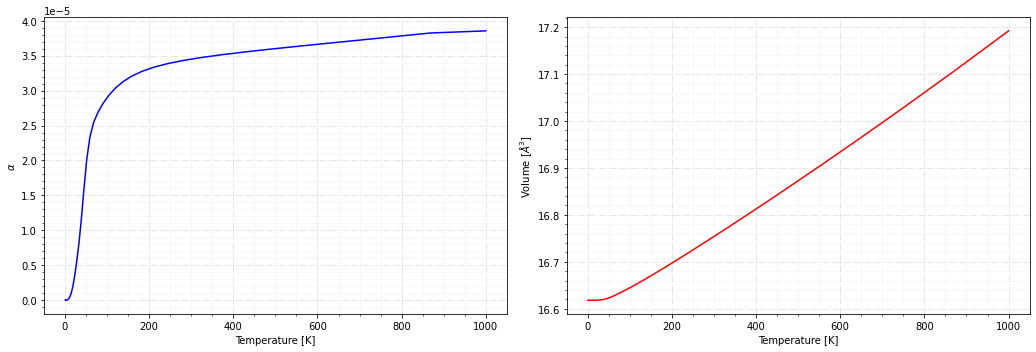

In [28]:

# Set up tempertaures to evaluate 
temperatures = np.geomspace(1, 1000, num=50, endpoint=True)

equi_volumes = []

for temperature in temperatures:
    thermal_energies = debye_model.vibrational_free_energies(temperature, volumes)
    free_energies_total = thermal_energies + free_energies
    eos = EosFactory("birch_murnaghan", volumes, free_energies_total)
    equi_volumes.append(eos.volume_eq)

equi_volumes = np.array(equi_volumes)

alpha = np.gradient(equi_volumes, temperatures) / (equi_volumes)

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(14.5, 5)

axes[0].plot(temperatures, alpha, color="blue")
axes[1].plot(temperatures, equi_volumes, color="red")

axes[0].set_ylabel(r"$\alpha$")
axes[1].set_ylabel(r"Volume [$\AA^3$]")


for ax in axes:
    ax.set_xlabel('Temperature [K]')
    ax.grid(b=True, which="major", color="grey", alpha=0.2, linestyle="dashdot", lw=1.0)
    ax.minorticks_on()
    ax.grid(b=True, which="minor", color="lightgrey", alpha=0.3, ls="-", lw=0.5)
    
fig.tight_layout()



### 2. Ag-Au

In [ ]:

# Define method for calculating the equilibrum volume

def calculate_equilibrium_volume(
    structure: Structure, volumes: Sequence[float], base_input_params: Dict, session
) -> float:
    """
    Calculate the equilibriums volume for the given structure
    """
    energies = []
    base_name = ""

    for comp in structure.species_and_occu:
        base_name += "".join([f"{k}{v:.8f}" for k, v in comp.as_dict().items()])

    for vol in volumes:
        result = session.run_main(
            PymatgenStructureAdapter(
                structure,
                base_input_params,
                volume=vol,
                name=f"{base_name}-{vol:.6f}",
            )
        )
        energies.append(result["general"].total_free_energy)

    thermal_energies = QuasiharmonicApprox(
        volumes, energies, structure).vibrational_free_energies(300, volumes)

    volume = EosFactory("birch_murnaghan", volumes, thermal_energies + energies).volume_eq
    return (volume * 4) ** (1/3)




#### 2.1. Equilbrium lattice constant

#### 2.2. Bulk modulus 

#### 2.3. Thermal expansion

Setup the calculation enviroment.

In [ ]:
import sys

# Load with magic commands
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pymatgen import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from thermal_exp.core.eos import EosFactory
from thermal_exp.core.quasiharmonic import QuasiharmonicApprox

from gfalm.notebook.session import ParallelGreenAlmSession
from gfalm.notebook.session import init_client

from gfalm_utils.adapter import PymatgenStructureAdapter

client = init_client("mpi")

Run an equation of state calculation for the NiCoCr alloy.

In [ ]:
# Experimental lattice constant of NiCoCr at 300K
experimental_a = 3.563  # ang

# Experimental volume
experimental_volume = experimental_a ** 3 / 4

`GreenALM` has also adapters to the widely used [pymatgen](https://pymatgen.org/) library. This library has extensive classes for representations of structures and structure manipulations.


```python
dlm_mode = 5

structure = Structure(
    lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
    species=[{"Ni": 0.33334, "Co": 0.33333, "Cr": 0.33333}],
    coords=[[0.0, 0.0, 0.0]],
    site_properties={
        "mom": [[2.0, 2.0, 2.0]],
        "lsm_mode": [[5, 5, 5]],
        "lsf_params": [[3, 3, 3]],
    },
)
```

The site properties are used here to set parameters for the calculation. 


In [ ]:
dlm_mode = 5

# Pymatgen structure
structure = Structure(
    lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
    species=[{"Ni": 0.33334, "Co": 0.33333, "Cr": 0.33333}],
    coords=[[0.0, 0.0, 0.0]],
    site_properties={
        "mom": [[2.0, 2.0, 2.0]],
        "lsm_mode": [[dlm_mode, dlm_mode, dlm_mode]],
        "lsf_params": [[3, 3, 3]],
    },
)

finder = SpacegroupAnalyzer(structure)
finder.get_space_group_symbol()

In [ ]:
# Set up the range for the calculations
volumes = np.linspace(9.85, 12.5, 8)

### Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.set_xlabel(r"Volume [$\AA^3$]")
ax.set_ylabel("Energy [Ry]")
ax.set_xlim([np.min(volumes) - 0.1, np.max(volumes[-1]) + 0.1])
fig.suptitle("EOS of NiCoCr")
fig.tight_layout()
ax.grid(b=True, which="major", color="grey", alpha=0.2, linestyle="dashdot", lw=1.0)
ax.minorticks_on()
ax.grid(b=True, which="minor", color="lightgrey", alpha=0.3, ls="-", lw=0.5)
###


# Define an list for the free energies
free_energies = []

with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    for idx, volume in enumerate(volumes):

        session.reset_pbar()
        session.write(f"Calculating for volume: {volume:.6f} ang^3", file=sys.stderr)

        base_input_params = session.read_input_file("input/nicocr_eos.in")
        result = session.run_main(
            PymatgenStructureAdapter(
                structure, base_input_params, volume=volume, name=f"nicocr-{volume:.6f}"
            )
        )
        energy = result["general"].total_free_energy

        session.write(f"Free energy: {energy:.6f}", file=sys.stderr)

        free_energies.append(energy)

        ax.plot(volume, energy, "rx", label="$F(V)$", markersize=12)


eos_base = EosFactory("birch_murnaghan", volumes, free_energies)

debye_model = QuasiharmonicApprox(volumes, free_energies, structure)
thermal_energies = debye_model.vibrational_free_energies(300, volumes)
free_energies_total = thermal_energies + free_energies

eos = EosFactory("birch_murnaghan", volumes, free_energies_total)

### Plotting
ax.plot(volumes, free_energies_total, "b+", label="$F(V)+F_{vib}(V)$", markersize=12)
ax.axvline(eos_base.volume_eq, ls="--", color="red")
ax.axvline(eos.volume_eq, ls="--", color="blue")
ax.axvline(experimental_volume, ls="--", color="black", label="Exp.")
handles, labels = ax.get_legend_handles_labels()
unique_labels, indices = np.unique(labels, return_index=True)
ax.legend(np.array(handles)[indices], unique_labels)
fig.tight_layout()
###

Print all variable to the screen.

In [ ]:
# Print all variables
print(f"Equilibrium volume: {eos.volume_eq}")
print(f"Lattice constants: {np.cbrt(eos.volume_eq * 4)}")

print(
    f'Volume: {EosFactory("birch_murnaghan", volumes, free_energies_total).volume_eq}:.4f'
)

print(f"Gruneisen: {debye_model.grueneisen_parameter}")
print(f"Bulk Modulus: {debye_model.bulk_modulus}")

You can compare now all different outputs of the equation of states.

In [ ]:
for eos_type in ["murnaghan", "vinet", "morse"]:
    print(
        f"Volume {eos_type}: {EosFactory(eos_type, volumes, free_energies_total).volume_eq}:.4f"
    )

After obtaining now the equilibrium lattice constant, you will have to calculate the magnitude of the
Burger's vector.

In [ ]:
# Calculate burgers vector
burger_vector = (
    np.cbrt(eos.volume_eq * 4) / 2 * np.sqrt(np.sum(np.array([1, 1, 0]) ** 2))
)
print(f"Burgers vector: {burger_vector}")

### 2. Task: Misfit volumes

The misfit volume of an element in a given alloy quantifies the size mismatch between the element and the matrix. It reflects the average local atomic environment around
the element. The misfit volume of the $n$-type in an $N$-component alloy can be expressed in terms of
derivatives of alloy atomic volume with respect to composition. The misfit volume of any type-n atom $\Delta V_n$
can then be calculated as

$$\Delta V_n = \frac{\partial V}{\partial c_n}   -  \sum_{m=1}^N c_m \dfrac{\partial V}{\partial c_m}$$

In order to get now the $\Delta V_n$, we just need to calculate the derivative of the alloy volume with respect to
changes of the composition. This can be obtained by varying concentrations by finite small values and performing a
multi-dimensional linear regression to find the coefficients.

You will perform now a series of CPA calculations for systems with small deviations of the concentrations from the
original alloy and get equilibrium volume for each of them. Practically, we will always vary the concentration of one component
while keeping the ratio of the remaining components constant. In order to get stable an accurate results, one would
need to perform at least 4 variations per component. For the matter of time we will only consider 2 variations
per component. This will lead to a total of 7 equation of state calculations.


Prepare again the session. `calculate_equilibrium_volume` and `generate_species_concentrations` are helper
functions.

In [ ]:
from typing import Dict, Sequence
from pprint import pprint, pformat

import numpy as np
from pymatgen import Structure

from thermal_exp.core.eos import EosFactory
from thermal_exp.core.quasiharmonic import QuasiharmonicApprox

from gfalm_utils.adapter import PymatgenStructureAdapter
from gfalm_utils.utils import change_concentrations


def calculate_equilibrium_volume(
    structure: Structure, volumes: Sequence[float], base_input_params: Dict, session
) -> float:
    """
    Calculate the equilibriums volume for the given structure
    """
    energies = []
    base_name = ""

    for comp in structure.species_and_occu:
        base_name += "".join([f"{k}{v:.8f}" for k, v in comp.as_dict().items()])

    for vol in volumes:
        result = session.run_main(
            PymatgenStructureAdapter(
                structure,
                base_input_params,
                volume=vol,
                name=f"{base_name}-{vol:.6f}",
            )
        )
        energies.append(result["general"].total_free_energy)

    thermal_energies = QuasiharmonicApprox(
        volumes, energies, structure, bulk_modulue=165, grueneisen_parameter=2.85
    ).vibrational_free_energies(300, volumes)

    return EosFactory("birch_murnaghan", volumes, thermal_energies + energies).volume_eq


def generate_species_concentrations(species, concentrations, max_diff, steps):
    comp = []

    comp.append(
        {k: v for k, v in zip(species, change_concentrations(concentrations, 0.00, 0))}
    )

    for index in range(len(species)):
        for diff in np.linspace(-max_diff, max_diff, steps):
            comp.append(
                {
                    k: v
                    for k, v in zip(
                        species, change_concentrations(concentrations, diff, index)
                    )
                }
            )

    return comp


equil_volumes = []

compositions = generate_species_concentrations(
    ["Ni", "Co", "Cr"], [0.3334, 0.3333, 0.3333], 0.01, 2
)

volumes = np.linspace(9.85, 12.5, 8)

site_properties = {
    "mom": [[2.0, 2.0, 2.0]],
    "lsm_mode": [[5, 5, 5]],
    "lsf_params": [[3, 3, 3]],
}

The first point that will be calculated is the equilibrium volume of the alloy

In [ ]:
with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[0]

    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

print("Done!!")

Next we will calculate the variation of the Ni concentration in our NiCoCr alloy.

In [ ]:
with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[1]

    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)


with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[2]
    
    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

Next we will calculate the variation of the Co concentration in our NiCoCr alloy.

In [ ]:
with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[3]
    
    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[4]

    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

Next we will calculate the variation of the Cr concentration in our NiCoCr alloy.

In [ ]:
with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[5]

    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

with ParallelGreenAlmSession(client, work_dir="workdir") as session:
    base_input_params = session.read_input_file("input/nicocr.in")
    composition = compositions[6]

    session.reset_pbar()
    session.write("Calculating EOS of composition...", file=sys.stderr)
    session.write(pformat(composition), file=sys.stderr)

    volume = calculate_equilibrium_volume(
        Structure(
            lattice=[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]],
            species=[composition],
            coords=[[0.0, 0.0, 0.0]],
            site_properties=site_properties,
        ),
        volumes,
        base_input_params,
        session,
    )

    session.write(f"Volume: {volume:.4f}", file=sys.stderr)
    equil_volumes.append(volume)

print("Done!!")

Extract now the matrix of concentrations.

In [ ]:
equil_concentrations = np.array([list(v.values()) for v in compositions])

#### 2.1: Linear regression

As first step we have to calculate the derivative of the equilibrium volumes with respect to changes in the volumes.
The next step is to perform linear regression in the multi-dimensional space of concentration variables with the
connected equilibrium volumes.

1. Perform a least square fit on parameters $a_i$ of

    $$
       V = a_1 + a_2 * c_{Co} + a_3 * c_{Cr}
    $$

    where we already use the fact that $\sum_i c_i = 1$.



2. Obtain the derivatives of the volume with respect to changes in the concentration
    from the fit as

   $$
      \dfrac{\partial V}{\partial c_m}
   $$

3. Use this expression in the final formular for the misfit volumes

4. Calculate the misfit delta $\delta$ from misfit volumes

    $$
        \delta = \sqrt( \sum_n * c_n \Delta V_n^2  ) / (3 V_{alloy} )
    $$

Hints:

- Solve a linear least-squares problem, means performing the following optimization:

     $$ \min | A * x - b | $$
    
- Also keep in mind when taking the derivatives, that the equation in point 1 doesn't depend on $c_{Ni}$.



In [ ]:
from scipy.optimize import lsq_linear

b = np.array(equil_volumes)
ones = np.ones((b.shape[0], 1))
A = np.concatenate((ones, np.array(equil_concentrations)[:, 1:]), axis=1)

res = lsq_linear(A, b)
dVdcm = res.x
dVdcm[0] = 0

misfit_volumes = dVdcm - np.sum(np.mean(np.array(equil_concentrations), axis=0) @ dVdcm)
misfit_delta = np.sum(equil_concentrations[0] * misfit_volumes ** 2) / (
    3 * equil_volumes[0]
)

print(
    f"Misfit volume: "
    + " ".join(
        [f"{c}: {m:.4f}" for c, m in zip(compositions[0].keys(), misfit_volumes)]
    )
)
print(f"Misfit delta: {misfit_delta:.4f}")

Now let's plot our results and see how good the linear fit is.


In [ ]:
fig = plt.figure()
ax = plt.axes()

z = np.array(equil_volumes)
x = np.array(equil_concentrations)[:, 0]
y = np.array(equil_concentrations)[:, 1]
phi = np.array(equil_concentrations)[:, 2]

volumes = np.array(equil_volumes)
concentrations = np.array(equil_concentrations)

ones = np.ones((volumes.shape[0], 1))
A = np.concatenate((ones, concentrations[:, :2]), axis=1)

res = lsq_linear(A, volumes)


@np.vectorize
def hyperplane(x_val, y_val):
    return res.x[0] + res.x[1] * x_val + res.x[2] * y_val


xx, yy = np.meshgrid(
    np.linspace(np.min(x), np.max(x), 20), np.linspace(np.min(y), np.max(y), 20)
)

ax.plot(x[:3], z[:3], "1", color="red", label="Ni", markersize=12)
ax.plot(
    np.hstack((y[0], y[3:5])),
    np.hstack((z[0], z[3:5])),
    "x",
    color="blue",
    label="Co",
    markersize=12,
)
ax.plot(
    np.hstack((phi[0], phi[5:])),
    np.hstack((z[0], z[5:])),
    "+",
    color="green",
    label="Cr",
    markersize=12,
)

x_var = np.linspace(np.min(x) - 0.01, np.max(x) + 0.01, 30)
y_fixed = (1 - x_var) / 2.0
zx_var = hyperplane(x_var, y_fixed)
ax.plot(x_var, zx_var, ls="--", color="red", label="fit Ni", lw=1.5, alpha=0.5)

y_var = np.linspace(np.min(y) - 0.01, np.max(y) + 0.01, 30)
x_fixed = (1 - y_var) / 2.0
zy_var = hyperplane(x_fixed, y_var)
ax.plot(y_var, zy_var, ls="--", color="blue", label="fit Co", lw=1.5, alpha=0.5)

phi_var = np.linspace(np.min(phi) - 0.01, np.max(phi) + 0.01, 30)
x_fixed = (1 - phi_var) / 2.0
y_fixed = (1 - phi_var) / 2.0
zphi_var = hyperplane(x_fixed, y_fixed)
ax.plot(phi_var, zphi_var, ls="--", color="green", label="fit Cr", lw=1.5, alpha=0.5)

ax.set_ylabel(r"Volume [$\AA^3$]")
ax.set_xlabel(r"Concentration [at.%]")
handles, labels = ax.get_legend_handles_labels()
sorted_labels = ["Ni", "fit Ni", "Co", "fit Co", "Cr", "fit Cr"]
sorted_handles = [handles[labels.index(l)] for l in sorted_labels]
ax.axvline(1.0 / 3.0, ls="--", color="black", lw=1.5)
merged_labels = ["Ni", "Co", "Cr"]
merged_handles = [
    (sorted_handles[0], sorted_handles[1]),
    (sorted_handles[2], sorted_handles[3]),
    (sorted_handles[4], sorted_handles[5]),
]
ax.legend(
    labels=merged_labels,
    handles=merged_handles,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
    ncol=3,
)
ax.set_xlim((y_var[0], y_var[-1]))
fig.align_labels()
ax.grid(b=True, which="major", color="grey", alpha=0.2, linestyle="dashdot", lw=1.0)
ax.minorticks_on()
ax.grid(b=True, which="minor", color="lightgrey", alpha=0.3, ls="-", lw=0.5)
fig.tight_layout(pad=1.00)
fig.canvas.draw()

### 3. Task: Calculate the strength of the NiCoCr alloy and comparison with experiment

By combining experimental materials parameters and our calculated misfit parameter, we can predict
the initial yield strength of NiCoCr within VC solute strengthening model. The model will give the
so called critical resolved shear stress for the given temperature and strain rate. The expressions for
the $\tau_0$, $\Delta E_b$ and $\tau(T)$ are provided already. Your task is now to calculate the
finite temperture yield strenght of NiCoCr and compare it with the experimental results.

Single-crystalline measurement of the strength are rare. Most measurements are carried out on poly-crystalline
samples. There will be an additional strengthening contribution due to the grains.
It is based on the observation that grain boundaries are insurmountable borders for
dislocations and that the number of dislocations within a grain has an effect
on how stress builds up in the adjacent grain, which will eventually activate
 dislocation sources and thus enabling deformation in the neighbouring grain, too. This so called
 Hall-Petch contribution has to be substracted.

We will use a collection literature data and plot the yield strength versus inverse square-root of
grain size in NiCoCr (Hall–Petch scaling). From this plot we will extrapolate to infinite grain size which corresponds to
single-crystalline yield strength. To get the yield shear stress from our experiment, we will have to divide by the Taylor factor of 3.06 to obtain the
uniaxial tensile strength of an untextured fcc polycrystal. The Taylor factor is just an average orientation factor
that occurs because slip planes can be differently oriented in the polycrystal.


#### 3.1 Task: Predict the strength of NiCoCr

Now you will use the expressions form Varvenne-Curtin model to predict the yield stress.

Again, here is the expression for the zero-temperature yield strength

$$
  \tau_0 = A_{\tau} \left( \frac{\Gamma}{b^2}              \right)^{-\frac{1}{3} }
                 \left( G_V \frac{1 + \nu}{1 - \nu} \right)^{ \frac{4}{3} }
                 \delta^{ \frac{4}{3} }
$$

In [ ]:
import numpy as np
from scipy.constants import Boltzmann as kB

In [ ]:
def calculate_tau_yield_zero(a_tau, gamma, shear, poisson, burger_vector, delta):
    """
    This function calculates the zero-temperature yield shear stress
    """
    return (
        a_tau
        * (gamma / burger_vector ** 2) ** (-1 / 3)
        * (shear * (1 + poisson) / (1 - poisson)) ** (4 / 3)
        * delta ** (4 / 3)
    )

Energy barrier for the thermally activate flow of the dislocation follow as

$$
  E_b = A_{E}   \left( \frac{\Gamma}{b^2}          \right)^{\frac{1}{3} }
                 b^3
                 \left( G_V \frac{1 + \nu}{1 - \nu} \right)^{ \frac{2}{3} }
                 \delta^{ \frac{2}{3} }
$$

In [ ]:
def calculate_delta_e_b(a_e, gamma, shear, poisson, delta, burger_vector):
    """
    Calculated the energy barrier for flow
    """
    misfit_part = delta ** (2 / 3)  # No units
    elastic_part = (shear * (1 + poisson) / (1 - poisson)) ** (2 / 3)  # Pressure
    delta_e = (
        a_e
        * (gamma / burger_vector ** 2) ** (1 / 3)
        * burger_vector ** 3
        * misfit_part
        * elastic_part
    )

    return delta_e

Lastly, the standard thermal activation theory expression

$$
  \tau(T) =  \tau_0 \left(
                    1 - \left(
                    \dfrac{kT}{\Delta E_b} \ln{ \frac{\dot{\epsilon_0}}{\dot{\epsilon}} }
                    \right)
                    \right)
$$


In [ ]:
def calculate_tau_yield(
    tau_y_zero, temperature, delta_e_b, epsilon=5 * 10 ** -4, epsilon_zero=10 ** 4
):
    """
    Calculate yield shear stress for a given temperature
    """
    return tau_y_zero * (
        1.0
        - ((kB * temperature / delta_e_b) * np.log(epsilon_zero / epsilon))
        ** (2.0 / 3.0)
    )

In [ ]:
from pymatgen.core import FloatWithUnit

a_tau = 0.049
gamma = FloatWithUnit(70, unit="GPa*ang^2").to("MPa*ang^2")
shear = FloatWithUnit(105, unit="GPa").to("MPa")
poisson = 0.268
burger_vector = FloatWithUnit(2.51, unit="ang^2")
# The predicted delta is still quite wrong at the moment
delta = 0.02

tau_yield_zero = calculate_tau_yield_zero(
    a_tau, gamma, shear, poisson, burger_vector, delta
)

tau_yield_zero = FloatWithUnit(tau_yield_zero, unit="MPa")

a_e = 2.7

delta_e_b = calculate_delta_e_b(a_e, gamma, shear, poisson, delta, burger_vector)

delta_e_b = FloatWithUnit(delta_e_b, unit="MPa*ang^3").to("J")

temperature = FloatWithUnit(300, unit="K")

tau_yield = calculate_tau_yield(
    tau_yield_zero, temperature, delta_e_b, epsilon=5 * 10 ** -4, epsilon_zero=10 ** 4
)

tau_yield = FloatWithUnit(tau_yield, unit="MPa")

print(f"Tau yield zero: {tau_yield_zero:.4f} [MPa]")
print(f"Energy barrier: {delta_e_b.to('eV'):.4f} [eV]")
print(f"Tau yield: {tau_yield:.4f} [MPa]")

#### 3.2 Task: Compare to experimental value strength of NiCoCr

In order to be able to compare the theoretical results with experimental measurements, we provide you with poly-crystalline
yield strength measurements. The yield strength has two main contributions in our fcc HEA: Grain boundary and solid
solution strengthening. You will first have to subtract the grain boundary contribution. For that reason you can also
find aggregated literature data of yield strength; the so called Hall-Petch plot. The yield strength $\sigma$ is
plotted with respect to the inverse square-root
of grain size in NiCoCr (Hall–Petch scaling). The grain boundary strengthening contribution follows then
from the slop of the Hall-Petch plot at the given grain size of the sample. The grain size of the measured sample
was $41$ $\mu m$. A hint: don't forget about the Taylor orientation factor.

Here is an illustrative example on how to extract the grain boudary strenghening for a given grain size from
the Hall-Petch plot.

```python
grain_size = 100
sigma_hall_petch = 537 * 100** ( -1/2)
tau_hall_petch = sigma_hall_petch / 3.06
```


<div style="align: left; text-align:center;">
    <img src="./images/yield_stress.png" width="500px" />
    <div class="caption">Temperature dependence of the yield stress of the
equiatomic alloys and pure Ni</div>
</div>


<div style="align: left; text-align:center;">
    <img src="./images/hall_petch.png" width="500px" />
    <div class="caption">Aggregated literature data on yield strength versus inverse square-root of grain size in NiCoCr (Hall–Petch scaling)</div>
</div>



In [ ]:
grain_size = 41

tau_hall_petch = 537 * grain_size ** (-1 / 2) / 3.06

print(f"Hall-Petch: {tau_hall_petch:.2f} [MPa]")

sigma_poly_crytalline = 315

tau_experimental = sigma_poly_crytalline / 3.06 - tau_hall_petch

print(f"Experimental tau: {tau_experimental:.2f} [MPa]")
print(f"Theoretical tau: {tau_yield:.2f} [MPa]")

## Discussion and Outlook

Due to the limited resource and time we were now not able to show to full capabilities of our workflow. Production
level calculations show much better agreement with experiment. For the case of NiCoCr we were able to predict the
strength over a large temperature range based on the here presented workflow.

<div style="align: left; text-align:center;">
    <img src="./images/nicocr_temp_euromat.png" width="900px" />
    <div class="caption">Overview of production results of production level calculations</div>
</div>